In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 1
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.845679012345679, Loss: 0.679271415427879
Checkpoint 20, Accuracy: 0.8518518518518519, Loss: 0.6221581918221933
Checkpoint 30, Accuracy: 0.8580246913580247, Loss: 0.6508511437310113
Checkpoint 40, Accuracy: 0.8888888888888888, Loss: 0.5884389524106626
Checkpoint 50, Accuracy: 0.8827160493827161, Loss: 0.5859054282859519
Checkpoint 60, Accuracy: 0.8641975308641975, Loss: 0.4949209071971752
Checkpoint 70, Accuracy: 0.9012345679012346, Loss: 0.44493675231933594
Checkpoint 80, Accuracy: 0.9629629629629629, Loss: 0.4376652682269061
Checkpoint 90, Accuracy: 0.9382716049382716, Loss: 0.40568104496708624
Checkpoint 100, Accuracy: 0.9567901234567902, Loss: 0.34776073031955296
Checkpoint 110, Accuracy: 0.9506172839506173, Loss: 0.3294191007260923
Checkpoint 120, Accuracy: 0.9567901234567902, Loss: 0.3266990096480758
Checkpoint 130, Accuracy: 0.9567901234567902, Loss: 0.31926434128372755
Checkpoint 140, Accuracy: 0.9506172839506173, Loss: 0.3262164151227033
Checkpoint 15

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

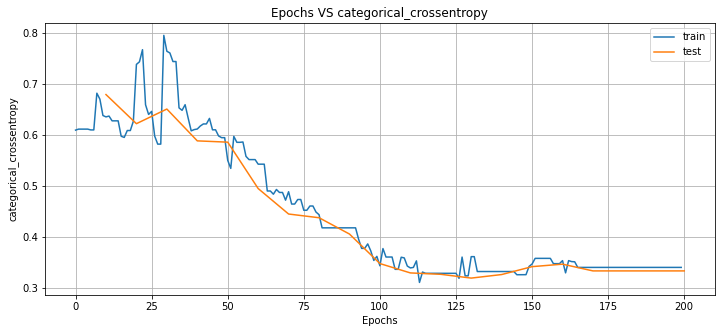

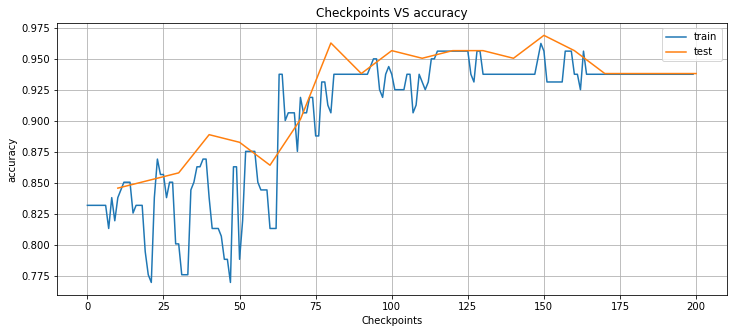

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.8319937  0.0948061  0.07320026]
[1. 0. 0.] <-> [0.82046044 0.05144626 0.12809339]
[1. 0. 0.] <-> [0.7267116  0.21276896 0.06051947]
[0. 1. 0.] <-> [0.41738525 0.5553718  0.02724286]
[1. 0. 0.] <-> [0.8035999  0.11331885 0.08308126]
[1. 0. 0.] <-> [0.83062613 0.09688132 0.07249255]
[0. 0. 1.] <-> [0.6856812  0.04029957 0.27401918]
[0. 0. 1.] <-> [0.28226006 0.01757606 0.7001639 ]
[1. 0. 0.] <-> [0.79312754 0.05657598 0.15029639]
[1. 0. 0.] <-> [0.73950607 0.07264742 0.18784645]
[1. 0. 0.] <-> [0.8086684  0.1276082  0.06372344]
[1. 0. 0.] <-> [0.8005785  0.09343463 0.1059869 ]
[1. 0. 0.] <-> [0.82608384 0.05666155 0.11725464]
[1. 0. 0.] <-> [0.83698696 0.08573975 0.07727331]
[0. 0. 1.] <-> [0.2147759  0.01527894 0.76994514]
[1. 0. 0.] <-> [0.7795347  0.16078322 0.05968202]
[1. 0. 0.] <-> [0.8212061  0.05799132 0.12080259]
[1. 0. 0.] <-> [0.76319355 0.06225417 0.17455228]
[1. 0. 0.] <-> [0.74613696 0.20063815 0.05322493]
[1. 0. 0.] <-> [0.8245569  0.07236689 0.10307617]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.845679012345679, 'mean_square_error': 0.40461493608956106, 'categorical_crossentropy': 0.679271415427879, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 25, 'tn_hit': 3, 'fn_hit': 0}, 1: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 14}, 2: {'tp_hit': 2, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 11}}, 'checkpoint': 10} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 0.3588085615297586, 'categorical_crossentropy': 0.6221581918221933, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 24, 'tn_hit': 4, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 9}}, 'checkpoint': 20} 


{'accuracy': 0.8580246913580247, 'mean_square_error': 0.3490058804859237, 'categorical_crossentropy': 0.6508511437310113, 'essential_metrics': {0: {'tp_hit': 80, 'fp_hit': 23, 'tn_hit': 5, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 15}, 2: {'tp_hit': 5, 'fp_hit': 0, 'tn_hit': 95, 'fn_hit': 

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-0.27826935  0.5539122   0.0480062  -0.8575927  -0.89741325]
 bias: 0.6121562123298645

Neuron 1: weights:
[-0.38645875  0.87806666  0.39398777  0.12378576 -0.46533033]
 bias: -0.3341049253940582

Neuron 2: weights:
[ 0.34426847 -0.7050461  -0.03993966  0.8576093   0.8697849 ]
 bias: -0.6713745594024658

Neuron 3: weights:
[ 0.64789134 -1.2444853  -0.77803147 -0.45251346  0.14029165]
 bias: 0.7753155827522278

$
Layer 2
Neuron 0: weights:
[ 0.83609444 -0.5240187  -0.7385916   1.234766  ]
 bias: 0.3585689961910248

Neuron 1: weights:
[ 0.4269345   1.4506707  -0.46471316 -1.7277246 ]
 bias: 0.07230211794376373

Neuron 2: weights:
[-1.6587552  -0.72522926  1.7882245   0.45013648]
 bias: -0.14158731698989868

$

